<a href="https://github.com/MaxWesterhout/Sistemas-de-Diagnostico-y-Tratamiento-I/tree/main/8_RNN_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# Redes Recurrentes (RNN)

Continuando con el estudio de las redes profundas, las redes recurrentes poseen la caracteristicas de guardar la información previa y entregarsela a la siguiente capa, con el fin de mantener la información secuencial de los datos.

![texto del vínculo](https://www.simplilearn.com/ice9/free_resources_article_thumb/Fully_connected_Recurrent_Neural_Network.gif)

In [1]:
!pip install -q nltk

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import re
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

#Stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
!gdown 1JEFdSRQ08RESzPBaBJVlzXRsvO6tdZ14 -O Symptom2Disease.csv

Downloading...
From: https://drive.google.com/uc?id=1JEFdSRQ08RESzPBaBJVlzXRsvO6tdZ14
To: /content/Symptom2Disease.csv
100% 230k/230k [00:00<00:00, 160MB/s]


## Symptom2Disease ([Link](https://www.kaggle.com/datasets/niyarrbarman/symptom2disease))




In [3]:
dat = pd.read_csv('https://raw.githubusercontent.com/MaxWesterhout/Sistemas-de-Diagnostico-y-Tratamiento-I/refs/heads/main/data/Symptom2DiseaseClase8.csv')
dat.head()

,Unnamed: 0,label,text
0,0,Psoriasis,I have been experiencing a skin rash on my arm...
1,1,Psoriasis,"My skin has been peeling, especially on my kne..."
2,2,Psoriasis,I have been experiencing joint pain in my fing...
3,3,Psoriasis,"There is a silver like dusting on my skin, esp..."
4,4,Psoriasis,"My nails have small dents or pits in them, and..."


In [4]:
#24 Labels
dat['label'].value_counts()

,count
label,
Psoriasis,50
Varicose Veins,50
Typhoid,50
Chicken pox,50
Impetigo,50
Dengue,50
Fungal infection,50
Common Cold,50
Pneumonia,50


In [5]:
dat['text'][0]

'I have been experiencing a skin rash on my arms, legs, and torso for the past few weeks. It is red, itchy, and covered in dry, scaly patches.'

## Preprocesamiento

codigo de preprocesamiento modificado desde [kaggle](https://www.kaggle.com/code/yannansu/symptom2disease-with-neural-networks-92-accuracy#Build-and-train-model)

### Label Encoder

In [6]:
def label_encode(labels):
    label_encoder = LabelEncoder()
    label_encoder.fit(labels)
    label_sequences = label_encoder.transform(labels)
    return label_sequences

# test: random sample 5 labels in dat and corresponding sequences
for i in np.random.randint(0, len(dat['label']), 5):
    print(dat['label'][i], label_encode(dat['label'])[i])

dat['label_encoded'] = label_encode(dat['label'])

Varicose Veins 17
Typhoid 16
Cervical spondylosis 3
Psoriasis 15
Dengue 6


### Train - Test split

In [7]:
train_ratio = 0.8
# sample 80% of the data for training and 20% for validation for each label
train = dat.groupby('label_encoded', group_keys=False).apply(lambda x: x.sample(frac=train_ratio, random_state=42))
val = dat.drop(train.index)

train_texts = train['text'].values
train_labels = train['label_encoded'].values
val_texts = val['text'].values
val_labels = val['label_encoded'].values

train_texts.shape, train_labels.shape, val_texts.shape, val_labels.shape

<ipython-input-7-602544770ced>:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train = dat.groupby('label_encoded', group_keys=False).apply(lambda x: x.sample(frac=train_ratio, random_state=42))


((960,), (960,), (240,), (240,))

### Remover stopwords

In [8]:
def remove_stopwords(texts):
    # first remove all punctuations
    words = [re.split(r'[ ,.]+', text) for text in texts]

    # remove space and make all words lower case
    words = [[word.lower() for word in text if word != ''] for text in words]

    # remove stop words using nltk (or you can use your own stop words, see below)
    stop_words = set(stopwords.words('english'))

    words = [[word for word in text if word.lower() not in stop_words] for text in words]
    return words

print(train_texts[0])
# test the function
print()
print(remove_stopwords(train_texts)[0])

A nasty rash has just appeared on my skin. Blackheads and pimples packed with pus are everywhere. Additionally, my skin has been extremely sensitive.

['nasty', 'rash', 'appeared', 'skin', 'blackheads', 'pimples', 'packed', 'pus', 'everywhere', 'additionally', 'skin', 'extremely', 'sensitive']


In [9]:
# make a tokenizer
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(train_texts)

def tokenize_and_pad(words, tokenizer, max_len=50):
    # convert the text to sequences of integers
    sequences = tokenizer.texts_to_sequences(words)
    # pad the sequences using the maxlen to make all sequences the same length
    padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post')
    return padded_sequences

# test the function
print(train_texts[0], end="\n\n")
print(len(train_texts[0].split(" ")), end="\n\n")
tokenize_and_pad(train_texts, tokenizer)[0]

A nasty rash has just appeared on my skin. Blackheads and pimples packed with pus are everywhere. Additionally, my skin has been extremely sensitive.

24



array([  5, 287,  46,  13, 177, 562,  22,   3,  16, 133,   2,  92, 637,
        24, 134,  18, 400,  89,   3,  16,  13,   6,  98, 269,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

In [10]:
train_sequences = tokenize_and_pad(remove_stopwords(train_texts), tokenizer)
train_labels = train_labels.reshape(-1, 1)

val_sequences = tokenize_and_pad(remove_stopwords(val_texts), tokenizer)
val_labels = val_labels.reshape(-1, 1)

print('train_sequences shape: ', train_sequences.shape)
print('train_labels shape: ', train_labels.shape)
print('val_sequences shape: ', val_sequences.shape)
print('val_labels shape: ', val_labels.shape)

train_sequences shape:  (960, 50)
train_labels shape:  (960, 1)
val_sequences shape:  (240, 50)
val_labels shape:  (240, 1)


In [11]:
def plot_graphs(history, metric):
    fig, ax = plt.subplots(figsize=(5, 3))
    ax.plot(history.history[metric])
    ax.plot(history.history['val_'+metric])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])
    plt.title(metric)
    plt.show()

## Modelos

![texto del vínculo](https://miro.medium.com/v2/resize:fit:720/format:webp/1*LfH52lSd1mq-UrWuejzO8g.png)

In [12]:
from keras.callbacks import LearningRateScheduler, ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
def get_callbacks():
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
    early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
    return [reduce_lr, early_stop]

In [13]:
max_length = len(train_sequences[0]) # 50

# Construcción del modelo con capa GRU
model_GRU = tf.keras.Sequential([
    tf.keras.Input(shape=(max_length,)),
    tf.keras.layers.Embedding(input_dim=3000, output_dim=256),
    tf.keras.layers.GRU(64, go_backwards=True),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(24, activation='softmax')  # Para clasificación multiclase
])

# Mostrar la arquitectura del modelo
model_GRU.summary()

# Compilación del modelo
model_GRU.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 50, 256)        │       768,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 64)             │        61,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 24)             │           792 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 832,696 (3.18 MB)

 Trainable params: 832,696 (3.18 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model_GRU.fit(train_sequences, train_labels, epochs=30, validation_data=(val_sequences, val_labels), callbacks=get_callbacks())

Epoch 1/30
30/30 [==============================] - 19s 255ms/step - loss: 3.1454 - accuracy: 0.1573 - val_loss: 3.0841 - val_accuracy: 0.2375 - lr: 0.0010
Epoch 2/30
30/30 [==============================] - 3s 111ms/step - loss: 2.8488 - accuracy: 0.3063 - val_loss: 2.5033 - val_accuracy: 0.3292 - lr: 0.0010
Epoch 3/30
30/30 [==============================] - 2s 82ms/step - loss: 1.9485 - accuracy: 0.4542 - val_loss: 1.7266 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/30
30/30 [==============================] - 1s 44ms/step - loss: 1.0748 - accuracy: 0.7719 - val_loss: 1.1836 - val_accuracy: 0.6958 - lr: 0.0010
Epoch 5/30
30/30 [==============================] - 1s 42ms/step - loss: 0.5437 - accuracy: 0.9229 - val_loss: 0.9778 - val_accuracy: 0.7417 - lr: 0.0010
Epoch 6/30
30/30 [==============================] - 1s 30ms/step - loss: 0.2998 - accuracy: 0.9729 - val_loss: 0.8387 - val_accuracy: 0.8125 - lr: 0.0010
Epoch 7/30
30/30 [==============================] - 0s 9ms/step - loss: 0

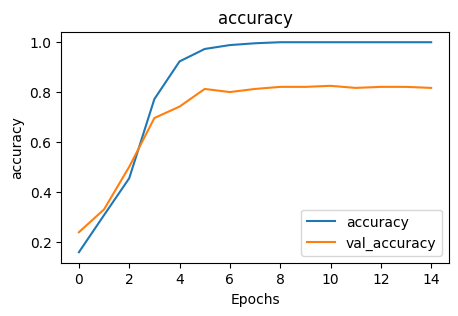

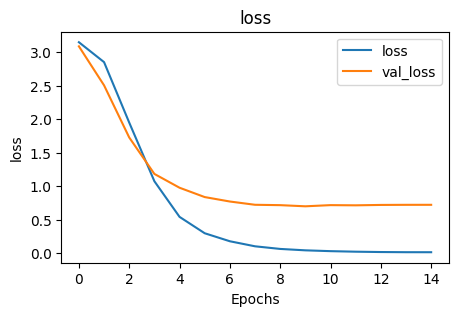

In [ ]:
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

## Actividad 1
Visualice la evolución de los pesos de la predicción al añadir secuencialmente palabras como input Ej:



```
Frase : I've just developed a skin rash with several pus-filled pimples and blackheads.

Input 1: I've
Input 2: I've just
Input 3: I've just developed
...
Input N: I've just developed a skin rash with several pus-filled pimples and blackheads.
```



In [ ]:
#Hint la función de remove_stopwords acepta un arreglo con arreglos

#Prográmame

## Actividad 2
Entrene un nuevo modelo cambiando la capa GRU por una capa LTSM y compare los resultados
![texto del vínculo](https://miro.medium.com/v2/resize:fit:720/format:webp/1*7cMfenu76BZCzdKWCfBABA.png)

In [ ]:
#build the model with LTSM layer

#Prográmame

## Anexo

GRU INTERNO

![texto del vínculo](https://www.researchgate.net/profile/Abien-Fred-Agarap/publication/319642918/figure/fig33/AS:631648458657812@1527608136275/mage-from-38-The-GRU-model-combines-the-forget-gate-and-input-gate-into-a-single.png)

GRU INTERNO

![texto del vínculo](https://i.sstatic.net/5wZpY.png
)

LSTM INTERNO

![texto del vínculo](https://www.researchgate.net/profile/Savvas-Varsamopoulos/publication/329362532/figure/fig5/AS:699592479870977@1543807253596/Structure-of-the-LSTM-cell-and-equations-that-describe-the-gates-of-an-LSTM-cell.jpg)